In [ ]:
pip install cv2

In [35]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random # To pick random samples for plotting

# Unzip the Dataset
zip_file_path = "Dataset.zip"  # Replace with the actual path to your zip file
extract_dir = "."  # Extract to the current directory

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Successfully extracted '{zip_file_path}' to '{extract_dir}'")
except zipfile.BadZipFile:
    print(f"Error: '{zip_file_path}' is not a valid zip file.")
except FileNotFoundError:
    print(f"Error: The file '{zip_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred during extraction: {e}")


# Data Loading and Preprocessing
def load_and_preprocess_data(data_dir):
    images = []
    labels = []
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if os.path.isdir(folder_path):
            for image_file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_file)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
                if image is not None:
                    image = cv2.resize(image, (50, 50))  # Resize for consistency
                    images.append(image)
                    labels.append(folder)
    return np.array(images), np.array(labels)

# Main Data Loading
train_dir = 'Dataset/train'  # Changed to 'Dataset/train'
val_dir = 'Dataset/val'    # Changed to 'Dataset/val'
test_dir = 'Dataset/test'   # Changed to 'Dataset/test'

train_images, train_labels = load_and_preprocess_data(train_dir)
val_images, val_labels = load_and_preprocess_data(val_dir)
test_images, test_labels = load_and_preprocess_data(test_dir)

# Expand dimensions to (None, 50, 50, 1)
train_images = np.expand_dims(train_images, axis=-1)
val_images = np.expand_dims(val_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)


# Label Encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# One-hot encode the labels
train_labels_categorical = to_categorical(train_labels_encoded)
val_labels_categorical = to_categorical(val_labels_encoded)
test_labels_categorical = to_categorical(test_labels_encoded)


# Normalize pixel values to be between 0 and 1
train_images = train_images.astype('float32') / 255.0
val_images = val_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels_categorical.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels_categorical.shape)

Successfully extracted 'Dataset.zip' to '.'
Train images shape: (6895, 50, 50, 1)
Train labels shape: (6895, 10)
Test images shape: (985, 50, 50, 1)
Test labels shape: (985, 10)


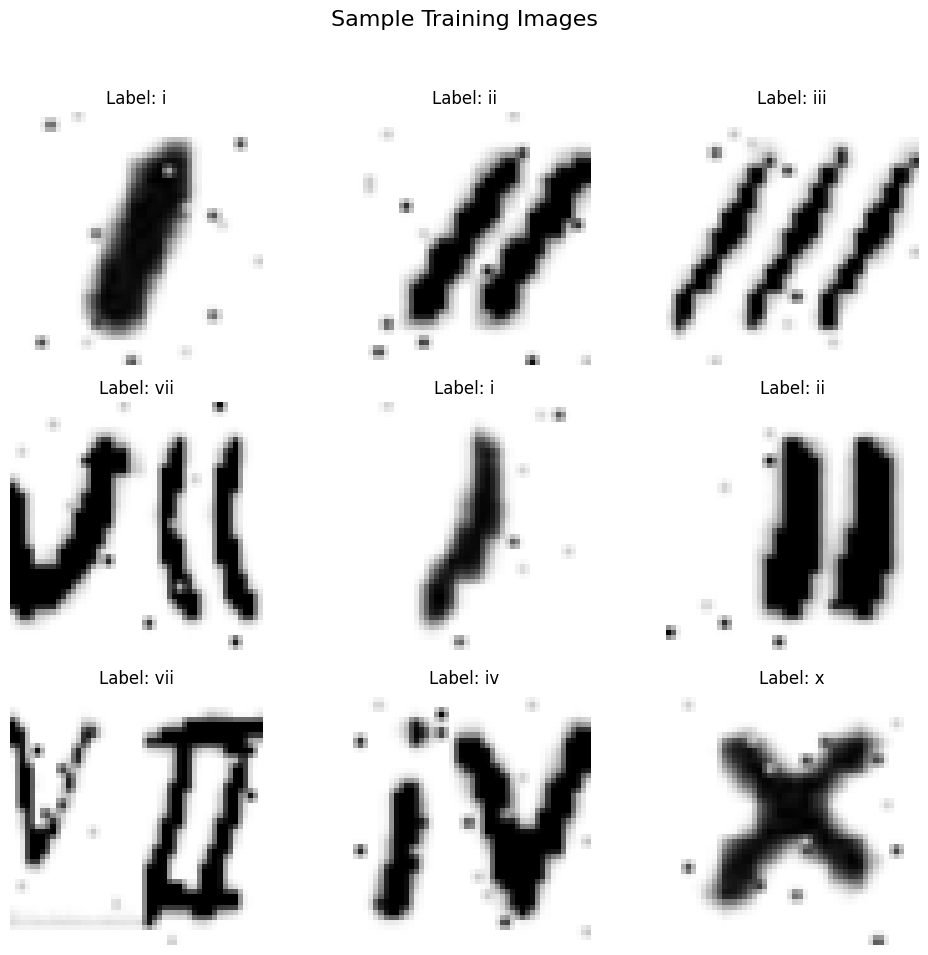

In [36]:
# --- Plot Sample Images ---

# Get the original string labels for plotting titles
class_names = label_encoder.classes_

plt.figure(figsize=(10, 10))
# Select 9 random images from the training set
random_indices = random.sample(range(len(train_images)), 9)

for i, index in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    # Squeeze removes the channel dimension (1) for grayscale display
    plt.imshow(np.squeeze(train_images[index]), cmap='gray')
    # Find the original label string corresponding to the one-hot encoded vector
    label_index = np.argmax(train_labels_categorical[index])
    plt.title(f"Label: {class_names[label_index]}")
    plt.axis('off')

plt.suptitle("Sample Training Images", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

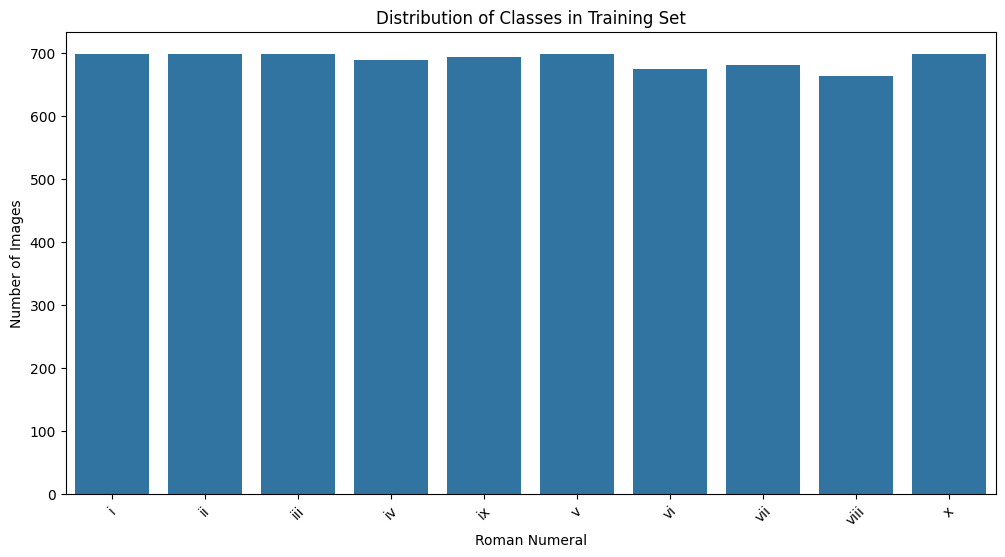

In [37]:
# --- Plot Class Distribution ---

# Use the original train_labels before encoding
unique_labels, counts = np.unique(train_labels, return_counts=True)

plt.figure(figsize=(12, 6))
sns.barplot(x=unique_labels, y=counts)
plt.title('Distribution of Classes in Training Set')
plt.xlabel('Roman Numeral')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# You could repeat this for val_labels and test_labels if desired
# unique_labels_test, counts_test = np.unique(test_labels, return_counts=True)
# print("Test Set Class Counts:", dict(zip(unique_labels_test, counts_test)))

In [38]:
# Model Architecture (Convolutional Neural Network)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,234 (1.36 MB)

 Trainable params: 356,234 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Model Training
history = model.fit(
    train_images, train_labels_categorical,
    validation_data=(val_images, val_labels_categorical),
    epochs=20,  # You can adjust the number of epochs
    batch_size=32
)

# Model Evaluation
test_loss, test_accuracy = model.evaluate(test_images, test_labels_categorical, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.4929 - loss: 1.4544 - val_accuracy: 0.9233 - val_loss: 0.2376
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9094 - loss: 0.2924 - val_accuracy: 0.9589 - val_loss: 0.1486
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9457 - loss: 0.1734 - val_accuracy: 0.9695 - val_loss: 0.1113
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9653 - loss: 0.1182 - val_accuracy: 0.9721 - val_loss: 0.0966
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9749 - loss: 0.0920 - val_accuracy: 0.9700 - val_loss: 0.1091
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9753 - loss: 0.0824 - val_accuracy: 0.9736 - val_loss: 0.0908
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9807 - loss: 0.0630 - val_accuracy: 0.9695 - val_loss: 0.1110
Epoch 8/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9850 - loss: 0.0519 - val_accuracy: 0

In [48]:
# Model Evaluation
test_loss, test_accuracy = model.evaluate(test_images, test_labels_categorical, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 98.38%


In [49]:
def predict_roman_numeral(image_path, model, label_encoder):
    """
    Predicts the Roman numeral in a given image.

    Args:
        image_path (str): Path to the image file.
        model: Trained Keras model.
        label_encoder: LabelEncoder used for encoding.

    Returns:
        str: Predicted Roman numeral, or None if prediction fails.
    """
    try:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Error: Could not read image at {image_path}")
            return None
        image = cv2.resize(image, (50, 50))
        image = np.expand_dims(image, axis=0)  # Add batch dimension
        image = np.expand_dims(image, axis=-1) # Add channel dimension
        image = image.astype('float32') / 255.0

        prediction = model.predict(image)
        predicted_class_index = np.argmax(prediction)
        predicted_roman_numeral = label_encoder.inverse_transform([predicted_class_index])[0]
        return predicted_roman_numeral
    except Exception as e:
        print(f"An error occurred during prediction: {e}")
        return None

In [50]:
# Example Usage:
test_image_path = "/content/samplee3.png"  # Replace with a valid test image path
predicted_numeral = predict_roman_numeral(test_image_path, model, label_encoder)

if predicted_numeral:
    print(f"Predicted Roman Numeral: {predicted_numeral}")
else:
    print("Prediction failed.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Roman Numeral: vii


In [51]:
# Save the trained model
model.save('roman_numeral_predictor.keras')
print("Model saved as 'roman_numeral_predictor.keras'")

Model saved as 'roman_numeral_predictor.keras'


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


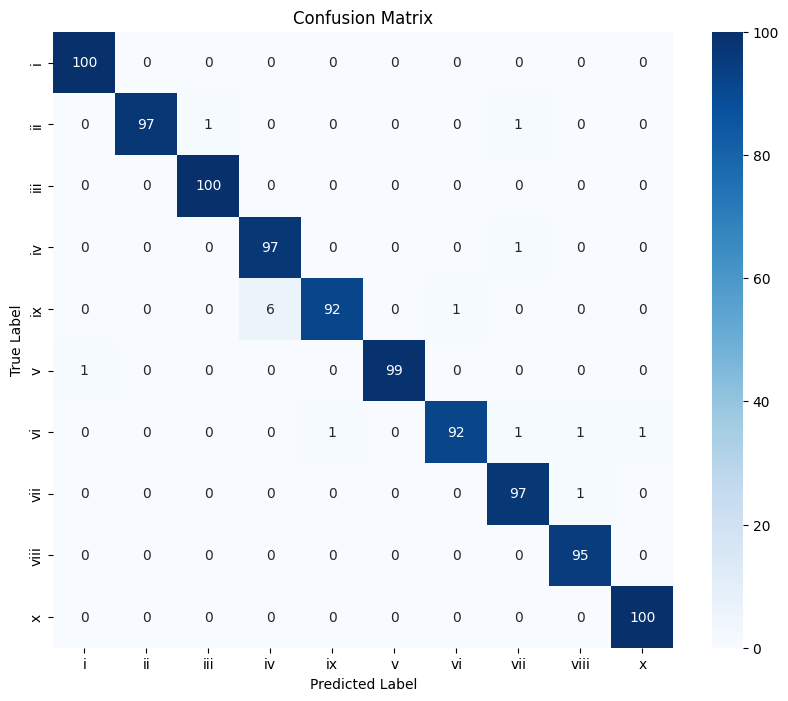

\nClassification Report:\n
              precision    recall  f1-score   support

           i       0.99      1.00      1.00       100
          ii       1.00      0.98      0.99        99
         iii       0.99      1.00      1.00       100
          iv       0.94      0.99      0.97        98
          ix       0.99      0.93      0.96        99
           v       1.00      0.99      0.99       100
          vi       0.99      0.96      0.97        96
         vii       0.97      0.99      0.98        98
        viii       0.98      1.00      0.99        95
           x       0.99      1.00      1.00       100

    accuracy                           0.98       985
   macro avg       0.98      0.98      0.98       985
weighted avg       0.98      0.98      0.98       985



In [52]:
# --- Plot Confusion Matrix and Classification Report ---

# Get predictions on the test set
y_pred_probs = model.predict(test_images)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get true labels (convert from one-hot)
y_true_classes = np.argmax(test_labels_categorical, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print the classification report
print("\\nClassification Report:\\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.metrics import confusion_matrix, classification_report

# ✅ 1. Plot Training & Validation Accuracy and Loss
def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'go-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

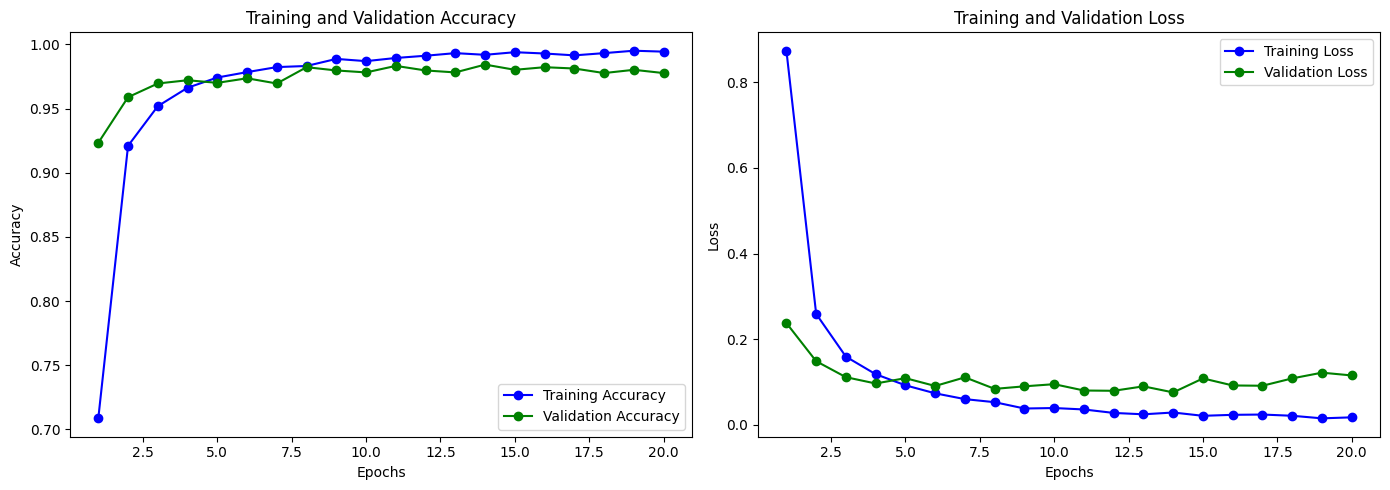

In [54]:
# Make sure val_generator was created with shuffle=False
plot_training_curves(history)



In [55]:
print('done')

done
